In [1]:
import numpy as np
import pandas as pd
import glob
import os
import sys
PROJECT_REPO_DIR = os.path.abspath('../../MIMIC-IV/PC-HMM')
sys.path.append(PROJECT_REPO_DIR)
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'pcvae'))

from pcvae.datasets.toy import toy_line, custom_dataset, custom_regression_dataset
from pcvae.models.hmm import HMM
from pcvae.datasets.base import dataset, real_dataset, classification_dataset, make_dataset

import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score)

import seaborn as sns
# sys.path.append(os.path.abspath('../PC-HMM/'))
# from main_mimic_semi_supervised_ordinal import compute_binary_classification_perf
%matplotlib inline

In [2]:
os.path.abspath('../')

'/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU'

## Get performance of PC-HMM classification as a function of % labelled sequences

In [3]:
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/eicu_v2.0/ordinal_los_prediction/'
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
bc_perf_dict_list = []
for min_los in [3, 5, 7]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

        # curr_perf_df
        try:
            best_ind = np.argmax(valid_auprc_np)
            perf_df = pd.read_csv(perf_csvs[best_ind])
            best_model_perf_csv = perf_csvs[best_ind]

#         print('test AUPRC of best model for LOS classification > %d days: %.3f'%(min_los, 
#                                                                                  perf_df['test_AUPRC'].values[-1]))
#         print('test AUC of best model for LOS classification > %d days : %.3f'%(min_los, 
#                                                                                 perf_df['test AUC'].values[-1]))

        
        
            x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH,  'los_geq_%d_days_prediction'%min_los,'X_test.npy')
            y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH,  'los_geq_%d_days_prediction'%min_los,'y_test.npy')

            best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

            print('best_model : %s'%best_model_weights)
            X_test = np.load(x_test_np_filename)
            y_test = np.load(y_test_np_filename)


            X_test = np.expand_dims(X_test, 1)

            # standardize data for PC-HMM
            key_list = ['train', 'valid', 'test']
            data_dict = dict.fromkeys(key_list)
            data_dict['train'] = (X_test, y_test)
            data_dict['valid'] = (X_test, y_test)
            data_dict['test'] = (X_test, y_test)
            data = custom_dataset(data_dict=data_dict)

            # load the best PCHMM model

            n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])

            model = HMM(states=n_states,
                        observation_dist='NormalWithMissing',
                        predictor_dist='Categorical')

            model.build(data)
            model.model.load_weights(best_model_weights)

            x_test, y_test = data.test().numpy()
            z_test = model.hmm_model.predict(x_test)
            y_test_pred_proba = model._predictor.predict(z_test)
            labelled_inds_te = ~np.isnan(y_test[:,0])
            test_roc_auc = roc_auc_score(y_test[labelled_inds_te], y_test_pred_proba[labelled_inds_te])
            test_auprc = average_precision_score(y_test[labelled_inds_te, 1], y_test_pred_proba[labelled_inds_te, 1])
        except:
            test_roc_auc=np.nan
            test_auprc=np.nan

        bc_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

bc_perf_df = pd.DataFrame(bc_perf_dict_list)

best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.005-seed=817-init_strategy=kmeans-batch_size=512-min_los=3-predictor_l2_penalty=0.1-perc_labelled=1.2-n_states=5-lamb=500-weights.h5
Class dist 0.43801394351090456
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.480
test AUROC : 0.563
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.005-seed=817-init_strategy=kmeans-batch_size=1024-min_los=3-predictor_l2_penalty=0.1-perc_labelled=3.7-n_states=5-lamb=500-weights.h5
Class dist 0.43801394351090456
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.503
test AUROC : 0.580
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.005-seed=24-init_strategy=kmeans-batch_size=1024-min_los=3-predictor_l2_penalty=0-perc_labelled=11.1-n_states=5-lamb=500-weights.h5
Class dist 0.43801394351090456
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.521
test AUROC : 0.588
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.005-seed=437-init_strategy=kmeans-batch_size=512-min_los=3-predictor_l2_penalty=0-perc_labelled=33.3-n_states=5-lamb=500-weights.h5
Class dist 0.43801394351090456
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.555
test AUROC : 0.618
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.005-seed=817-init_strategy=kmeans-batch_size=512-min_los=3-predictor_l2_penalty=0-perc_labelled=100-n_states=5-lamb=500-weights.h5
Class dist 0.43801394351090456
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.562
test AUROC : 0.624
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.001-seed=24-init_strategy=kmeans-batch_size=256-min_los=5-predictor_l2_penalty=0-perc_labelled=1.2-n_states=5-lamb=1000-weights.h5
Class dist 0.22014658562745798
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 5 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.251
test AUROC : 0.571
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.001-seed=817-init_strategy=kmeans-batch_size=256-min_los=5-predictor_l2_penalty=0-perc_labelled=3.7-n_states=5-lamb=1000-weights.h5
Class dist 0.22014658562745798
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 5 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.289
test AUROC : 0.581
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.001-seed=24-init_strategy=kmeans-batch_size=256-min_los=5-predictor_l2_penalty=0-perc_labelled=11.1-n_states=5-lamb=1000-weights.h5
Class dist 0.22014658562745798
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 5 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.295
test AUROC : 0.594
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.005-seed=24-init_strategy=kmeans-batch_size=512-min_los=5-predictor_l2_penalty=0-perc_labelled=33.3-n_states=5-lamb=5000-weights.h5
Class dist 0.22014658562745798
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 5 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.328
test AUROC : 0.635
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.005-seed=24-init_strategy=kmeans-batch_size=512-min_los=5-predictor_l2_penalty=0-perc_labelled=100-n_states=5-lamb=5000-weights.h5
Class dist 0.22014658562745798
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 5 days classification with 100 perc labelled sequences=========
test AUPRC : 0.341
test AUROC : 0.650
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.001-seed=817-init_strategy=kmeans-batch_size=256-min_los=7-predictor_l2_penalty=0-perc_labelled=1.2-n_states=5-lamb=1000-weights.h5
Class dist 0.13098855917053986
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.185
test AUROC : 0.598
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.001-seed=24-init_strategy=kmeans-batch_size=256-min_los=7-predictor_l2_penalty=0-perc_labelled=3.7-n_states=5-lamb=1000-weights.h5
Class dist 0.13098855917053986
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.202
test AUROC : 0.596
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.001-seed=24-init_strategy=kmeans-batch_size=256-min_los=7-predictor_l2_penalty=0-perc_labelled=11.1-n_states=5-lamb=1000-weights.h5
Class dist 0.13098855917053986
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.186
test AUROC : 0.593
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.005-seed=24-init_strategy=kmeans-batch_size=1024-min_los=7-predictor_l2_penalty=0-perc_labelled=33.3-n_states=5-lamb=500-weights.h5
Class dist 0.13098855917053986
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 7 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.226
test AUROC : 0.655
best_model : /cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_classification/semi-supervised-pchmm-lr=0.005-seed=817-init_strategy=kmeans-batch_size=1024-min_los=7-predictor_l2_penalty=0-perc_labelled=100-n_states=5-lamb=500-weights.h5
Class dist 0.13098855917053986
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


================LOS > 7 days classification with 100 perc labelled sequences=========
test AUPRC : 0.233
test AUROC : 0.660


## Evaluate performance for ordinal regression

In [4]:
def compute_binary_classification_perf(y, y_pred_proba_NC):
    # Get the predicted probabilities of los>=3 days
    y_pred_proba_N3 = np.sum(y_pred_proba_NC[:, 1:], axis=1)
    
    # get the true labels for los>=3 days
    y_N3 = (y>=1)*1
    
    # Get the predicted probabilities of los>=7 days
    y_pred_proba_N7 = np.sum(y_pred_proba_NC[:, 2:], axis=1)
    
    # get the true labels for los>=7 days
    y_N7 = (y>=2)*1
    
    # Get the predicted probabilities of los>=11 days
    y_pred_proba_N11 = y_pred_proba_NC[:, 3]
    
    # get the true labels for los>=7 days
    y_N11 = (y==3)*1
    
    labelled_inds = ~np.isnan(y)
    auprc_3 = average_precision_score(y_N3[labelled_inds], y_pred_proba_N3[labelled_inds])
    roc_auc_3 = roc_auc_score(y_N3[labelled_inds], y_pred_proba_N3[labelled_inds])
    
    auprc_7 = average_precision_score(y_N7[labelled_inds], y_pred_proba_N7[labelled_inds])
    roc_auc_7 = roc_auc_score(y_N7[labelled_inds], y_pred_proba_N7[labelled_inds])
    
    auprc_11 = average_precision_score(y_N11[labelled_inds], y_pred_proba_N11[labelled_inds])
    roc_auc_11 = roc_auc_score(y_N11[labelled_inds], y_pred_proba_N11[labelled_inds])
    
    
    return y_N3, y_pred_proba_N3, auprc_3, roc_auc_3, y_N7, y_pred_proba_N7, auprc_7, roc_auc_7, y_N11, y_pred_proba_N11, auprc_11, roc_auc_11

## Get the PC-HMM ordinal regression performance as a function of percent labelled sequences

In [5]:
ordinal_perf_dict_list = []
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
CLF_TRAIN_TEST_SPLIT_PATH = '/cluster/tufts/hugheslab/datasets/eicu_v2.0/ordinal_los_prediction/los_prediction_ordinal'
for perc_labelled in perc_labelled_list:
    perf_csvs = glob.glob(os.path.abspath('../results/PCHMM/los_ordinal_regression/final_perf*perc_labelled=%s*n_states=*-*.csv'%perc_labelled))


    valid_auprc_np_3 = np.zeros(len(perf_csvs))
    test_auprc_np_3 = np.zeros(len(perf_csvs))
    valid_auprc_np_7 = np.zeros(len(perf_csvs))
    test_auprc_np_7 = np.zeros(len(perf_csvs))
    valid_auprc_np_11 = np.zeros(len(perf_csvs))
    test_auprc_np_11 = np.zeros(len(perf_csvs))

    for ii, perf_csv in enumerate(perf_csvs):
        curr_perf_df = pd.read_csv(perf_csv)
        valid_auprc_np_3[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
        test_auprc_np_3[ii] = curr_perf_df['test_AUPRC_3'].values[-1]

        valid_auprc_np_7[ii] = curr_perf_df['valid_AUPRC_5'].values[-1]
        test_auprc_np_7[ii] = curr_perf_df['test_AUPRC_5'].values[-1]

        valid_auprc_np_11[ii] = curr_perf_df['valid_AUPRC_7'].values[-1]
        test_auprc_np_11[ii] = curr_perf_df['test_AUPRC_7'].values[-1]


    best_ind = np.argmax(valid_auprc_np_3)
    perf_df = pd.read_csv(perf_csvs[best_ind])
    best_model_perf_csv = perf_csvs[best_ind]


    x_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH , 'X_test.npy')
    y_test_np_filename=os.path.join(CLF_TRAIN_TEST_SPLIT_PATH, 'y_test.npy')

    best_model_weights = best_model_perf_csv.replace('.csv', '-weights.h5').replace('final_perf_', '')

    X_test = np.load(x_test_np_filename)
    y_test = np.load(y_test_np_filename)


    X_test = np.expand_dims(X_test, 1)

    # standardize data for PC-HMM
    key_list = ['train', 'valid', 'test']
    data_dict = dict.fromkeys(key_list)
    data_dict['train'] = (X_test, y_test)
    data_dict['valid'] = (X_test, y_test)
    data_dict['test'] = (X_test, y_test)
    data = custom_regression_dataset(data_dict=data_dict)

    # load the best PCHMM model
    print(best_model_weights)
    n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])
    
    model = HMM(states=n_states,
                observation_dist='NormalWithMissing',
                predictor_dist='OrderedLogistic')

    model.build(data)
    model.model.load_weights(best_model_weights)

    x_test, y_test = data.test().numpy()
    z_test = model.hmm_model.predict(x_test)

    y_test_pred_proba_NC = model._predictor(z_test).distribution.categorical_probs().numpy().squeeze()

    y_test_N3, y_test_pred_proba_N3, test_auprc_3, test_roc_auc_3, y_test_N7, y_test_pred_proba_N7, test_auprc_7, test_roc_auc_7, y_test_N11, y_test_pred_proba_N11, test_auprc_11, test_roc_auc_11 = compute_binary_classification_perf(y_test, y_test_pred_proba_NC)

    for min_los, y_test, y_test_pred_proba  in [(3, y_test_N3, y_test_pred_proba_N3),
                                                (5, y_test_N7, y_test_pred_proba_N7),
                                                (7, y_test_N11, y_test_pred_proba_N11)]:
        
        print('=======Percent labelled = %s========='%perc_labelled)
        print('test AUPRC of best model for LOS classification > %d days: %.3f'%(min_los, 
                                                                                 perf_df['test_AUPRC_%s'%min_los].values[-1]))
        print('test AUC of best model for LOS classification > %d days : %.3f'%(min_los, 
                                                                                perf_df['test AUC_%s'%min_los].values[-1]))
        
        ordinal_perf_dict_list.append({'min_los' : min_los,
                                       'perc_labelled' : perc_labelled,
                                       'test_AUC' : perf_df['test AUC_%s'%min_los].values[-1],
                                       'test_AUPRC' : perf_df['test_AUPRC_%s'%min_los].values[-1]}
                                     )

ordinal_perf_df = pd.DataFrame(ordinal_perf_dict_list)

/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_ordinal_regression/semi-supervised-pchmm-lr=0.005-seed=517-init_strategy=kmeans-batch_size=1024-predictor_l2_penalty=0-perc_labelled=1.2-n_states=5-lamb=500-weights.h5
Class dist 0.7891490883089024
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


=======Percent labelled = 1.2=========
test AUPRC of best model for LOS classification > 3 days: 0.485
test AUC of best model for LOS classification > 3 days : 0.554
=======Percent labelled = 1.2=========
test AUPRC of best model for LOS classification > 5 days: 0.256
test AUC of best model for LOS classification > 5 days : 0.549
=======Percent labelled = 1.2=========
test AUPRC of best model for LOS classification > 7 days: 0.152
test AUC of best model for LOS classification > 7 days : 0.541
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_ordinal_regression/semi-supervised-pchmm-lr=0.005-seed=109-init_strategy=kmeans-batch_size=512-predictor_l2_penalty=0.1-perc_labelled=3.7-n_states=5-lamb=500-weights.h5
Class dist 0.7891490883089024
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


=======Percent labelled = 3.7=========
test AUPRC of best model for LOS classification > 3 days: 0.498
test AUC of best model for LOS classification > 3 days : 0.568
=======Percent labelled = 3.7=========
test AUPRC of best model for LOS classification > 5 days: 0.274
test AUC of best model for LOS classification > 5 days : 0.571
=======Percent labelled = 3.7=========
test AUPRC of best model for LOS classification > 7 days: 0.168
test AUC of best model for LOS classification > 7 days : 0.568
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_ordinal_regression/semi-supervised-pchmm-lr=0.005-seed=517-init_strategy=kmeans-batch_size=1024-predictor_l2_penalty=0-perc_labelled=11.1-n_states=5-lamb=500-weights.h5
Class dist 0.7891490883089024
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


=======Percent labelled = 11.1=========
test AUPRC of best model for LOS classification > 3 days: 0.529
test AUC of best model for LOS classification > 3 days : 0.596
=======Percent labelled = 11.1=========
test AUPRC of best model for LOS classification > 5 days: 0.307
test AUC of best model for LOS classification > 5 days : 0.611
=======Percent labelled = 11.1=========
test AUPRC of best model for LOS classification > 7 days: 0.197
test AUC of best model for LOS classification > 7 days : 0.619
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_ordinal_regression/semi-supervised-pchmm-lr=0.005-seed=517-init_strategy=kmeans-batch_size=512-predictor_l2_penalty=0.1-perc_labelled=33.3-n_states=5-lamb=500-weights.h5
Class dist 0.7891490883089024
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


=======Percent labelled = 33.3=========
test AUPRC of best model for LOS classification > 3 days: 0.559
test AUC of best model for LOS classification > 3 days : 0.624
=======Percent labelled = 33.3=========
test AUPRC of best model for LOS classification > 5 days: 0.342
test AUC of best model for LOS classification > 5 days : 0.653
=======Percent labelled = 33.3=========
test AUPRC of best model for LOS classification > 7 days: 0.230
test AUC of best model for LOS classification > 7 days : 0.667
/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_ordinal_regression/semi-supervised-pchmm-lr=0.005-seed=817-init_strategy=kmeans-batch_size=512-predictor_l2_penalty=0.1-perc_labelled=100-n_states=5-lamb=5000-weights.h5
Class dist 0.7891490883089024
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


=======Percent labelled = 100=========
test AUPRC of best model for LOS classification > 3 days: 0.575
test AUC of best model for LOS classification > 3 days : 0.637
=======Percent labelled = 100=========
test AUPRC of best model for LOS classification > 5 days: 0.359
test AUC of best model for LOS classification > 5 days : 0.662
=======Percent labelled = 100=========
test AUPRC of best model for LOS classification > 7 days: 0.244
test AUC of best model for LOS classification > 7 days : 0.676


## Get performance of GRU-D classification as a function of % labelled sequences

In [6]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
grud_perf_dict_list = []
for min_los in [3, 5, 7]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/GRUD/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]
        
        try:
            # curr_perf_df
            best_ind = np.argmax(valid_auprc_np)
            perf_df = pd.read_csv(perf_csvs[best_ind])
            best_model_perf_csv = perf_csvs[best_ind]

            test_roc_auc = perf_df['test_AUC']
            test_auprc = perf_df['test_AUPRC']
        except:
            test_roc_auc=np.nan
            test_auprc=np.nan
        
        
        grud_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

grud_perf_df = pd.DataFrame(grud_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.478
test AUROC : 0.549
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.494
test AUROC : 0.560
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.501
test AUROC : 0.571
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.521
test AUROC : 0.597
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.561
test AUROC : 0.631
================LOS > 5 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.253
test AUROC : 0.557
================LOS > 5 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.269
test AUROC : 0.571
================LOS > 5 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.274
test AUROC : 0.577
=====

In [12]:
grud_perf_df

,min_los,perc_labelled,test_AUC,test_AUPRC
0,3,1.2,"0 0.54853 Name: test_AUC, dtype: float64","0 0.478158 Name: test_AUPRC, dtype: float64"
1,3,3.7,"0 0.560328 Name: test_AUC, dtype: float64","0 0.494478 Name: test_AUPRC, dtype: float64"
2,3,11.1,"0 0.571021 Name: test_AUC, dtype: float64","0 0.501078 Name: test_AUPRC, dtype: float64"
3,3,33.3,"0 0.596697 Name: test_AUC, dtype: float64","0 0.521147 Name: test_AUPRC, dtype: float64"
4,3,100,"0 0.630726 Name: test_AUC, dtype: float64","0 0.56114 Name: test_AUPRC, dtype: float64"
5,5,1.2,"0 0.55724 Name: test_AUC, dtype: float64","0 0.253332 Name: test_AUPRC, dtype: float64"
6,5,3.7,"0 0.570947 Name: test_AUC, dtype: float64","0 0.268604 Name: test_AUPRC, dtype: float64"
7,5,11.1,"0 0.577199 Name: test_AUC, dtype: float64","0 0.274046 Name: test_AUPRC, dtype: float64"
8,5,33.3,"0 0.600592 Name: test_AUC, dtype: float64","0 0.29372 Name: test_AUPRC, dtype: float64"
9,5,100,"0 0.649913 Name: test_AUC, dtype: float64","0 0.337924 Name: test_AUPRC, dtype: float64"


In [18]:
mixmatch_perf_df = grud_perf_df.copy()
mixmatch_auprc_np = np.array([0.441, 0.454, 0.468, 0.502, 0.531, 0.223, 0.239, 0.245, 0.258, 0.296, 0.140, 0.147, 0.155, 0.160, 0.183])
mixmatch_perf_df['test_AUPRC']=mixmatch_auprc_np


fixmatch_perf_df = grud_perf_df.copy()
fixmatch_auprc_np = np.array([0.428, 0.448, 0.465, 0.510, 0.524, 0.216, 0.224, 0.237, 0.251, 0.288, 0.137, 0.141, 0.159, 0.156, 0.179])
fixmatch_perf_df['test_AUPRC']=fixmatch_auprc_np

brits_perf_df = grud_perf_df.copy()
brits_auprc_np = np.array([0.452, 0.455, 0.464, 0.521, 0.538, 0.232, 0.239, 0.241, 0.257, 0.308, 0.143, 0.149, 0.165, 0.160, 0.191])
brits_perf_df['test_AUPRC']=brits_auprc_np



## Get the MixMatch Performance as a function of % labelled sequences

In [7]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
mixmatch_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/MixMatch/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

        # curr_perf_df
        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]
        
        test_roc_auc = perf_df['test_AUROC'].values[-1]
        test_auprc = perf_df['test_AUPRC'].values[-1]
        
        
        mixmatch_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

mixmatch_perf_df = pd.DataFrame(mixmatch_perf_dict_list)

ValueError: attempt to get argmax of an empty sequence

## Get FixMatch performance as a function of % labelled sequences

In [11]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
fixmatch_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/FixMatch/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC'].values[-1]

        # curr_perf_df
        best_ind = np.argmax(valid_auprc_np)
        perf_df = pd.read_csv(perf_csvs[best_ind])
        best_model_perf_csv = perf_csvs[best_ind]
        
        test_roc_auc = perf_df['test_AUROC'].values[-1]
        test_auprc = perf_df['test_AUPRC'].values[-1]
        
        
        fixmatch_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

fixmatch_perf_df = pd.DataFrame(fixmatch_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.508
test AUROC : 0.512
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.527
test AUROC : 0.541
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.512
test AUROC : 0.536
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.494
test AUROC : 0.497
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.502
test AUROC : 0.509
================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.201
test AUROC : 0.539
================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.217
test AUROC : 0.560
================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.210
test AUROC : 0.568
=====

## Get BRITS performance as a function of % labelled sequences

In [12]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
brits_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/BRITS/los_classification/final_perf*min_los=%d*perc_labelled=%s*.csv'%(min_los, perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['AUPRC_valid'].values[-1]
            test_auprc_np[ii] = curr_perf_df['AUPRC_test'].values[-1]

        # curr_perf_df
        try:
            best_ind = np.argmax(valid_auprc_np)
            perf_df = pd.read_csv(perf_csvs[best_ind])
            best_model_perf_csv = perf_csvs[best_ind]

            test_roc_auc = perf_df['AUC_test'].values[-1]
            test_auprc = perf_df['AUPRC_test'].values[-1]
        except:
            test_roc_auc=np.nan
            test_auprc=np.nan


        brits_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

brits_perf_df = pd.DataFrame(brits_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.510
test AUROC : 0.543
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.523
test AUROC : 0.551
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.569
test AUROC : 0.599
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.598
test AUROC : 0.627
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.679
test AUROC : 0.699
================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.210
test AUROC : 0.569
================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.200
test AUROC : 0.565
================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.209
test AUROC : 0.563
=====

## Get GRU-D ordinal regression performance as a function of % labelled

In [14]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
grud_ordinal_perf_dict_list = []
for min_los in [3, 5, 7]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/GRUD/los_ordinal_regression/final_perf*perc_labelled=%s*.csv'%(perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['valid_AUPRC_3'].values[-1]
            test_auprc_np[ii] = curr_perf_df['test_AUPRC_3'].values[-1]

        # curr_perf_df
        try:
            best_ind = np.argmax(valid_auprc_np)
            perf_df = pd.read_csv(perf_csvs[best_ind])
            best_model_perf_csv = perf_csvs[best_ind]

            test_roc_auc = perf_df['test AUC_%d'%min_los].values[-1]
            test_auprc = perf_df['test_AUPRC_%d'%min_los].values[-1]
        except:
            test_roc_auc=np.nan
            test_auprc=np.nan


        grud_ordinal_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

grud_ordinal_perf_df = pd.DataFrame(grud_ordinal_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.482
test AUROC : 0.558
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.500
test AUROC : 0.562
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.519
test AUROC : 0.588
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.538
test AUROC : 0.594
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.542
test AUROC : 0.592
================LOS > 5 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.257
test AUROC : 0.565
================LOS > 5 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.279
test AUROC : 0.580
================LOS > 5 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.296
test AUROC : 0.604
=====

## Get BRITS ordinal regression performance as a function of % labelled sequences

In [6]:
perc_labelled_list = ['1.2', '3.7', '11.1', '33.3', '100']
brits_ordinal_perf_dict_list = []
for min_los in [3, 7, 11]:
    
    for perc_labelled in perc_labelled_list:
    
        perf_csvs = glob.glob(os.path.abspath('../results/BRITS/los_ordinal_regression/*perc_labelled=%s*.csv'%(perc_labelled)))


        valid_auprc_np = np.zeros(len(perf_csvs))
        test_auprc_np = np.zeros(len(perf_csvs))

        for ii, perf_csv in enumerate(perf_csvs):
            curr_perf_df = pd.read_csv(perf_csv)
            valid_auprc_np[ii] = curr_perf_df['AUPRC_valid_3'].values[-1]
            test_auprc_np[ii] = curr_perf_df['AUPRC_test_3'].values[-1]

        # curr_perf_df
        try:
            best_ind = np.argmax(valid_auprc_np)
            perf_df = pd.read_csv(perf_csvs[best_ind])
            best_model_perf_csv = perf_csvs[best_ind]

            test_roc_auc = perf_df['AUC_test_%d'%min_los].values[-1]
            test_auprc = perf_df['AUPRC_test_%d'%min_los].values[-1]
        except:
            test_roc_auc=np.nan
            test_auprc=np.nan


        brits_ordinal_perf_dict_list.append({'min_los' : min_los,
                         'perc_labelled' : perc_labelled,
                         'test_AUC' : test_roc_auc,
                         'test_AUPRC' : test_auprc})
        
        
        
        print('================LOS > %s days classification with %s perc labelled sequences========='%(min_los, perc_labelled))
        print('test AUPRC : %.3f'%test_auprc)
        print('test AUROC : %.3f'%test_roc_auc)
        print('=====================================================================================')

brits_ordinal_perf_df = pd.DataFrame(brits_ordinal_perf_dict_list)

================LOS > 3 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.489
test AUROC : 0.515
================LOS > 3 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.504
test AUROC : 0.531
================LOS > 3 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.505
test AUROC : 0.542
================LOS > 3 days classification with 33.3 perc labelled sequences=========
test AUPRC : 0.519
test AUROC : 0.554
================LOS > 3 days classification with 100 perc labelled sequences=========
test AUPRC : 0.508
test AUROC : 0.536
================LOS > 7 days classification with 1.2 perc labelled sequences=========
test AUPRC : 0.173
test AUROC : 0.503
================LOS > 7 days classification with 3.7 perc labelled sequences=========
test AUPRC : 0.187
test AUROC : 0.539
================LOS > 7 days classification with 11.1 perc labelled sequences=========
test AUPRC : 0.180
test AUROC : 0.535
=====

## Plot ordinal regression vs binary classification SSL performance 

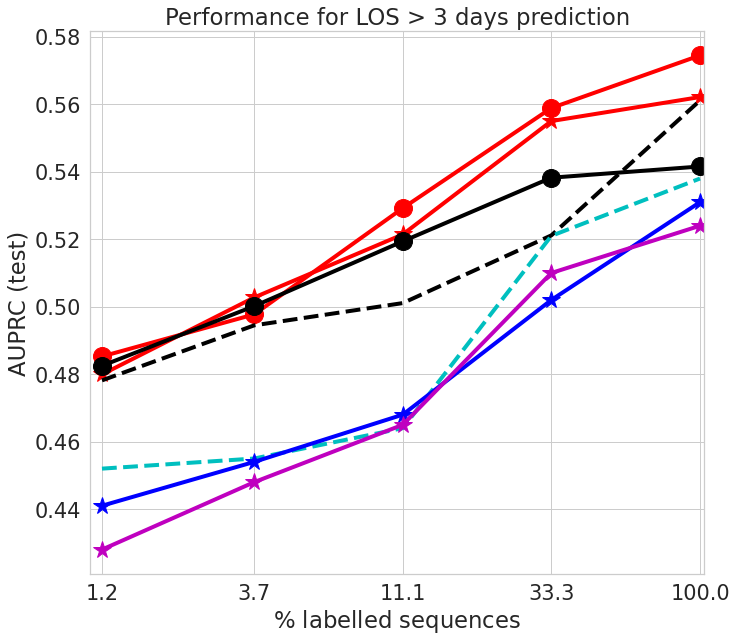

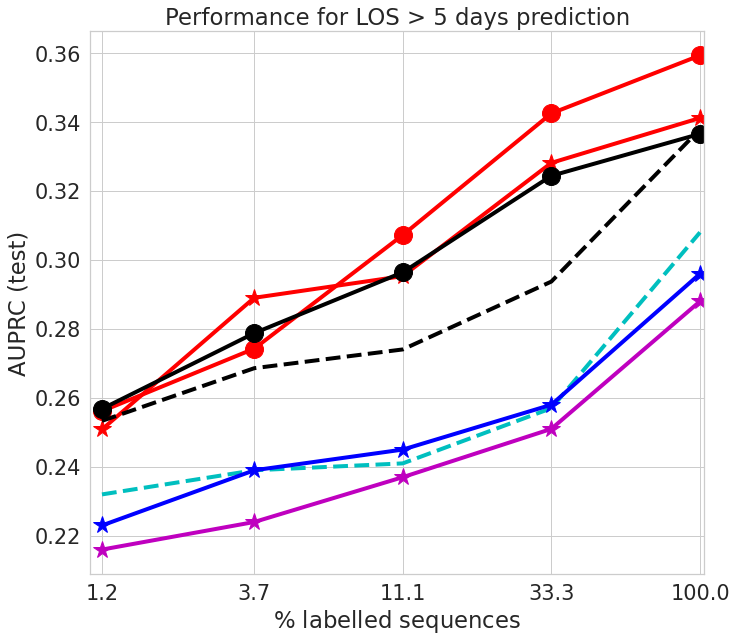

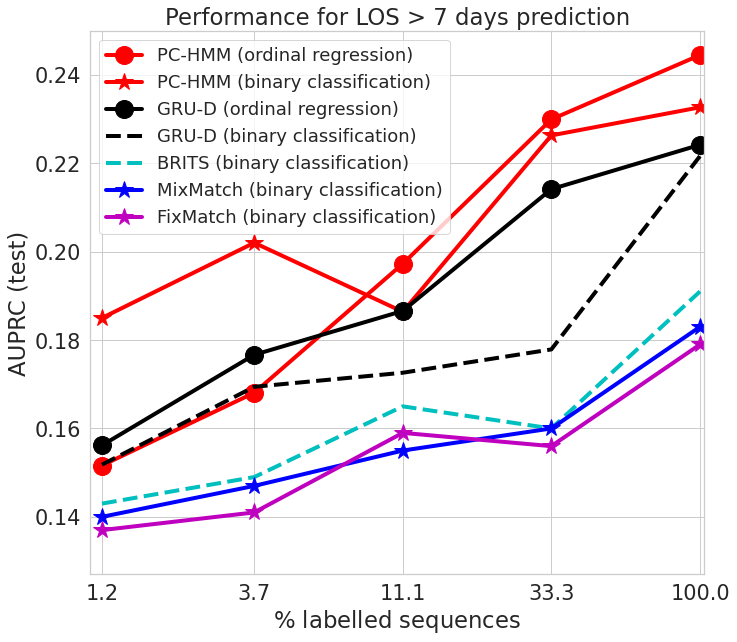

In [25]:
ordinal_perf_df['perc_labelled'] = ordinal_perf_df['perc_labelled'].astype(float)
bc_perf_df['perc_labelled'] = bc_perf_df['perc_labelled'].astype(float)
grud_perf_df['perc_labelled'] = grud_perf_df['perc_labelled'].astype(float)
mixmatch_perf_df['perc_labelled'] = mixmatch_perf_df['perc_labelled'].astype(float)
fixmatch_perf_df['perc_labelled'] = fixmatch_perf_df['perc_labelled'].astype(float)
brits_perf_df['perc_labelled'] = brits_perf_df['perc_labelled'].astype(float)
grud_ordinal_perf_df['perc_labelled'] = grud_ordinal_perf_df['perc_labelled'].astype(float)
# pchmm_20_state_ordinal_perf_df['perc_labelled'] = pchmm_20_state_ordinal_perf_df['perc_labelled'].astype(float)

ylims_list = [None,
             None,
             [0.127, 0.25]] 

for pp, min_los in enumerate([3, 5, 7]):
    f, axs = plt.subplots(1, 1, figsize=(11, 10))
    sns.set_context('notebook', font_scale=1.9)
    sns.set_style('whitegrid')
    curr_ordinal_perf_df = ordinal_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_bc_perf_df = bc_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_grud_perf_df = grud_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_mixmatch_perf_df = mixmatch_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_fixmatch_perf_df = fixmatch_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_brits_perf_df = brits_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    curr_grud_ordinal_perf_df = grud_ordinal_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
#     curr_pchmm_20_state_ordinal_perf_df = pchmm_20_state_ordinal_perf_df.query('min_los==%s'%min_los).sort_values(by='perc_labelled')
    
    
    perc_labelled = curr_ordinal_perf_df['perc_labelled'].values
    test_auprc_bc_np = curr_bc_perf_df['test_AUPRC'].values
    test_auprc_ordinal_np = curr_ordinal_perf_df['test_AUPRC'].values
    test_auprc_grud = curr_grud_perf_df['test_AUPRC'].values
    test_auprc_mixmatch = curr_mixmatch_perf_df['test_AUPRC'].values
    test_auprc_fixmatch = curr_fixmatch_perf_df['test_AUPRC'].values
    test_auprc_brits = curr_brits_perf_df['test_AUPRC'].values
    test_auprc_grud_ordinal = curr_grud_ordinal_perf_df['test_AUPRC'].values
#     test_auprc_pchmm_20_state_ordinal = curr_pchmm_20_state_ordinal_perf_df['test_AUPRC'].values
    
    
    lw=4
    markersize=18
    axs.plot(perc_labelled, test_auprc_ordinal_np, 'ro-', markersize=markersize, linewidth=lw, label='PC-HMM (ordinal regression)')
    axs.plot(perc_labelled, test_auprc_bc_np, 'r*-', markersize=markersize, linewidth=lw, label='PC-HMM (binary classification)')
    axs.plot(perc_labelled, test_auprc_grud_ordinal, 'ko-', markersize=markersize, 
             linewidth=lw, label='GRU-D (ordinal regression)')
    axs.plot(perc_labelled, test_auprc_grud, 'k--', linewidth=lw, label='GRU-D (binary classification)')
    axs.plot(perc_labelled, test_auprc_brits, 'c--', linewidth=lw, label='BRITS (binary classification)')
    axs.plot(perc_labelled, test_auprc_mixmatch, 'b*-', linewidth=lw, markersize=markersize, label='MixMatch (binary classification)')
    axs.plot(perc_labelled, test_auprc_fixmatch, 'm*-', linewidth=lw, markersize=markersize, label='FixMatch (binary classification)')
#     axs.plot(perc_labelled, test_auprc_pchmm_20_state_ordinal, '.-', 
#              label='20 state PC-HMM (ordinal regression)')
    
#     axs.legend(bbox_to_anchor=(0.99, 1.05))
    axs.set_title('Performance for LOS > %s days prediction'%min_los)
    
    axs.set_xscale('log')    
    axs.set_xticks(perc_labelled)
    axs.set_xticklabels(perc_labelled)
    
    axs.set_xlim([1.1, 103])
    if ylims_list[pp] is not None:
        axs.set_ylim(ylims_list[pp])
    if min_los==7:
        axs.legend(
#             bbox_to_anchor=(0.99, 1.05),
        loc='upper left', fontsize=18
        )
    
    axs.set_ylabel('AUPRC (test)')
    axs.set_xlabel(r'$\%$ labelled sequences')
    f.savefig('eicu_perf_los_geq_%s_days.pdf'%min_los, bbox_inches='tight')
    f.savefig('eicu_perf_los_geq_%s_days.png'%min_los, bbox_inches='tight')
    plt.show()
    